### Optimal solution: Z = 7293 miles | s = 0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0

In [1]:
import pandas as pd
import numpy as np
import copy
from numpy import random
import matplotlib.pyplot as plt
import networkx as nx

# start/end city
initial_city = 0

#distance matrix
distance_matrix = pd.DataFrame([
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
])

# random seed for visual
np.random.seed(33)

# graph and coords for distance matrix
G = nx.from_numpy_matrix(A = distance_matrix.to_numpy())
G = nx.DiGraph(G)
pos = nx.spring_layout(G)

/Users/adames/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Intermediate UDFs

In [2]:
def tsp_network_viz(s:str, initial_city:int, distance_matrix:pd.DataFrame,graph, pos:dict, figsize=(12,6)):
    '''TSP network visual'''

    # add starting and ending points to solution
    x = s.split('-')
    x = [eval(i) for i in x]
    x.insert(0,initial_city)
    x.insert(len(x),initial_city)

    # define order of visited cities and store total distance
    route , total_distance = [] , []
    for i in range(len(x)):
        if i < len(x)-1:
            total_distance.append(distance_matrix.iloc[x[i], x[i+1]])
            route.append( (x[i] , x[i+1]) )

    # figure size
    plt.figure(figsize=figsize) 

    # visual format
    node_colors = ['red' if i==0 else "green" for i in distance_matrix.index]
    options = {"edgecolors": "black", "node_size": 800, "alpha": 0.95, "edge_color":"black", "font_color":"whitesmoke"}

    # route visual
    nx.draw(G = graph, pos = pos ,with_labels=True, node_color = node_colors, edgelist = route,  arrowstyle='-|>', width= 2 ,**options)
    plt.title('Z = '+str(sum(total_distance)),loc = 'center', fontsize = 22);

def nearest_neighbor_initial_sol(start:int,distance_matrix:pd.DataFrame):
    '''Generates an initial solution using nearest neighbor.'''

    # first city cisited
    visited = [distance_matrix.loc[start, distance_matrix.columns != start].idxmin()]
    not_visited = [*set([*distance_matrix.columns]) - set(visited) - set([start])]

    # get min distance to next city
    while len(not_visited) != 0:
        next_city = distance_matrix.loc[visited[-1], not_visited].idxmin()
        visited.append(next_city)
        not_visited.remove(next_city)
    encoded_string = '-'.join([ str(w) for w in copy.copy(visited)])

    return encoded_string

def decoding(string:str):
    ''' adds depot to sequence'''
    
    # route seqeunce
    sequences = {}
    sequences.update({0: str(0)+'-'+string+'-'+str(0)})

    return sequences
    
def encoding(string:str, initial_city:int, distance_matrix:pd.DataFrame):
    ''' Return objective function for vehicle routing problem given a string of sequences where the delimeter | indicates a new vehicle'''

    # get cities in sequence
    l = [ int(x) for x in string.split('-') ] 
    l.insert(0,initial_city)
    l.insert(len(l),initial_city)

    # get distance traveled
    total_distance = []
    for i in range(len(l)):
        if i < len(l)-1:
            total_distance.append(distance_matrix.iloc[l[i], l[i+1]])

    # store total distances traveled by vehicle and total distance among all vehicles
    obj_val = sum(total_distance)

    return  obj_val
    
def pair_wise(s):
    'Generates a new sequence using an inut string'

    # get sequence for vehicle
    k = [ int(y) for y in copy.copy(s.split('-')) ] 

    # change two random positions
    a = np.random.randint(low = 1, high = len(s.split('-')) - 1 ,size=1)[0]
    b = np.random.randint(low = 1, high = len(s.split('-')) - 1 ,size=1)[0]
    k[a], k[b] = k[b], k[a]

    # create new encoded sequence
    new_sequence = '-'.join([ str(y) for y in copy.copy(k) ] )
    
    return new_sequence

### SA for TSP

Best trajectory found:
0 -> 7 -> 3 -> 2 -> 9 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 5 -> 10 -> 0


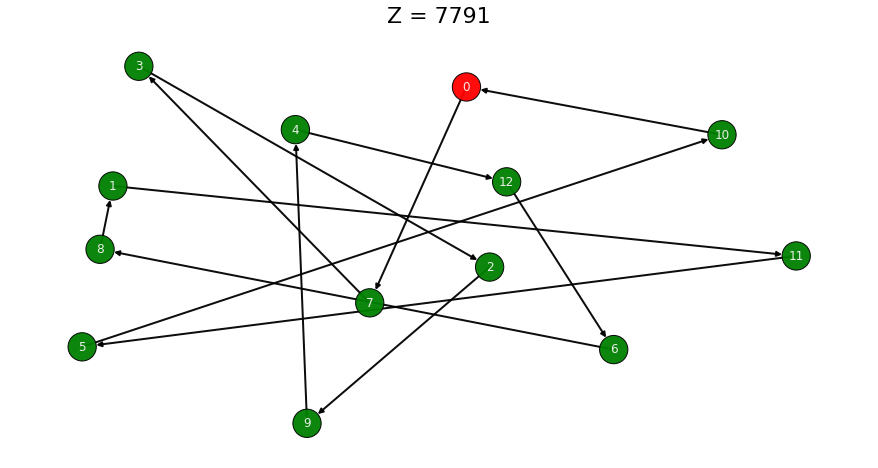

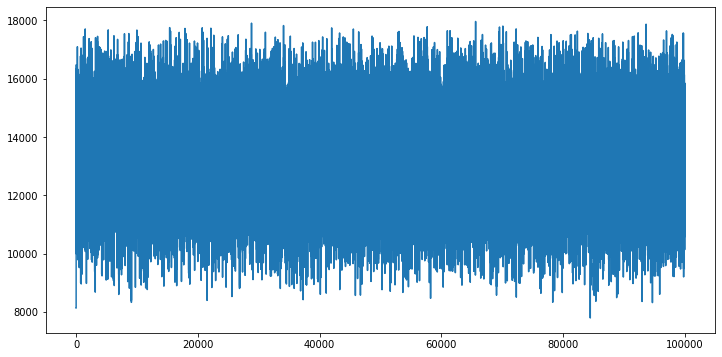

In [3]:
def simulated_annealing(inital_s:str, num_of_iters:int , initial_city:int ,  T_init:int , alpha:float , N:int, distance_matrix:pd.DataFrame):
    ''' main SA call'''

    # counter for while loop, list of all obj fun, list for strings of sols, sols sin mejorar en una temp, initial temp val, initial solution 
    i, Z, seqs, M, T, s = 1, {}, {}, 0, T_init, inital_s

    # encoding initial sol
    f_s = encoding(string = s, initial_city = initial_city,  distance_matrix = distance_matrix)

    # store initial sols
    seqs[0] = s
    Z[0] = f_s

    # iters of schedule
    while i < num_of_iters+1:

        # new sol
        s_new = pair_wise(s = s)
        f_s_new = encoding(string = s_new, initial_city = initial_city,  distance_matrix = distance_matrix)
        seqs[i] = s_new
        Z[i] = f_s_new

        # normal dist random nums
        threshold = np.random.uniform(0,1)

        # aceptance probability for new solution
        aceptance_prob = min(1, np.exp( (f_s - f_s_new) / T ) )

        # condition to reject or accept new solution
        if f_s_new <= f_s:
            s = s_new
            f_s = f_s_new
            M = 0
        else:
            if threshold < aceptance_prob:
                s = s_new
                f_s = f_s_new
                M = 0
            else:
                M += 1
                if M == N:
                    T = T*alpha
                    if T <= 0.1:
                        break
        i += 1
        
    # best sequence
    z,s = Z[min(Z, key=Z.get)], seqs[min(Z, key=Z.get)]
    return z, s, Z, seqs

# simulated annealing call
inital_s = nearest_neighbor_initial_sol(start = 0, distance_matrix = distance_matrix)
z , s , Z, seqs = simulated_annealing(inital_s = inital_s ,num_of_iters = 100000 ,initial_city = 0, T_init = 2500, alpha = 0.99, N = 250, distance_matrix=distance_matrix) 

#Print Results:
print('Best trajectory found:')
print(' -> '.join([ str(x) for x in (str(0)+'-'+s+'-'+str(0)).split('-') ] ))

# visual
tsp_network_viz(s = s, initial_city = 0, distance_matrix = distance_matrix, graph = G, pos = pos, figsize=(12,6))

# seqs
x = []
y = []
for i in Z.keys():
    x.append(i)
    y.append(Z[i])
plt.figure(figsize=(12,6)) 
plt.plot(x,y);

# lon que deberia reportar son los best solutions, osea cada vez que encuentr una mejores sols

### RL for TSP

Best trajectory found:
0 -> 7 -> 2 -> 9 -> 10 -> 5 -> 4 -> 12 -> 11 -> 1 -> 8 -> 6 -> 3 -> 0


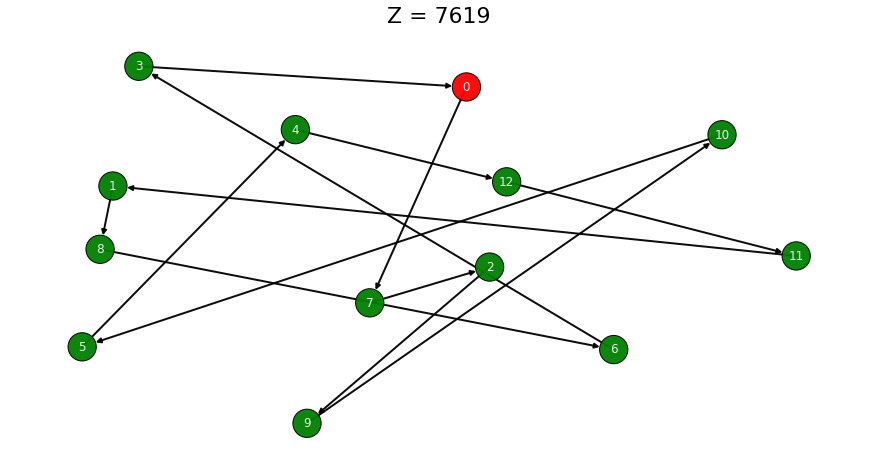

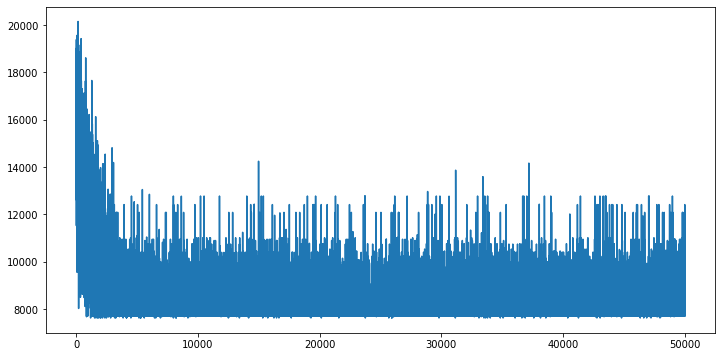

In [4]:
def update_q(q, distance_matrix, state, action, alpha, gamma):
    ''' Updates Q table for reinforcement learning'''

    # reward for current stage and action
    reward =  1/distance_matrix.loc[state,action]

    # max reward for next stage and activity value
    delayed_reward = q[action,:].max()

    # update q value
    q[state,action] = q[state,action] + alpha * (reward + gamma * delayed_reward -  q[state,action])

    return q

def reinforcement_learning(distance_matrix, exploration_proba, n_episodes, alpha, gamma):
    '''Main call for RL appied to TSP'''

    # initializing cities and q matrix
    cities = len(distance_matrix)
    q = np.zeros([cities,cities])

    # store values
    seqs, Z = {} , {}

    # exploration thresholds
    exploration_decreasing_decay , min_exploration_proba = 0.001 , 0.01

    # train model to learn from experience
    for e in range(n_episodes):
        # initial city as initial stat
        visited, state = [0] , 0

        # posible actions at initial state
        possible_actions = [ next_city for next_city in range(cities) if next_city not in visited]

        # iterate until all destinations are visited
        while possible_actions:
            if np.random.uniform(0,1) < exploration_proba:
                action = random.choice(possible_actions)
            else:       
                best_action_index = q[state, possible_actions].argmax()
                action = possible_actions[best_action_index]

            # update q table
            q = update_q(q, distance_matrix, state, action,alpha=alpha, gamma=gamma)
            visited.append(action)
            state = visited[-1]
            possible_actions = [ next_city for next_city in range(cities) if next_city not in visited]

        #We update the exploration proba using exponential decay formula 
        exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e)) 
        seqs[e] = '-'.join([str(y) for y in copy.copy(visited) if y!=0 ] ) #visited
        Z[e] = encoding(string = '-'.join([str(y) for y in copy.copy(visited) if y!=0 ] ), initial_city = initial_city,  distance_matrix = distance_matrix)
    
    # best sequence
    z,s = Z[min(Z, key=Z.get)], seqs[min(Z, key=Z.get)]
    return z, s, Z, seqs


# RL call
z, s, Z, seqs = reinforcement_learning(distance_matrix = distance_matrix, exploration_proba = 1, n_episodes = 50000, alpha=0.99, gamma=0.2)

#Print Results:
print('Best trajectory found:')
print(' -> '.join([ str(x) for x in (str(0)+'-'+s+'-'+str(0)).split('-') ] ))

# visual
tsp_network_viz(s = s, initial_city = 0, distance_matrix = distance_matrix, graph = G, pos = pos, figsize=(12,6))

# seqs
x = []
y = []
for i in Z.keys():
    x.append(i)
    y.append(Z[i])
plt.figure(figsize=(12,6)) 
plt.plot(x,y);

### RL then SA for TSP

Best trajectory found using RL + SA:
0 -> 7 -> 2 -> 9 -> 10 -> 5 -> 4 -> 12 -> 11 -> 1 -> 8 -> 6 -> 3 -> 0


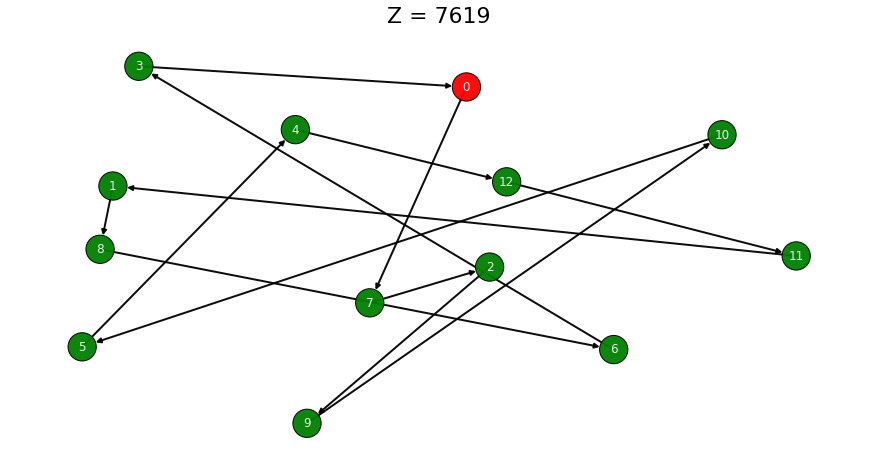

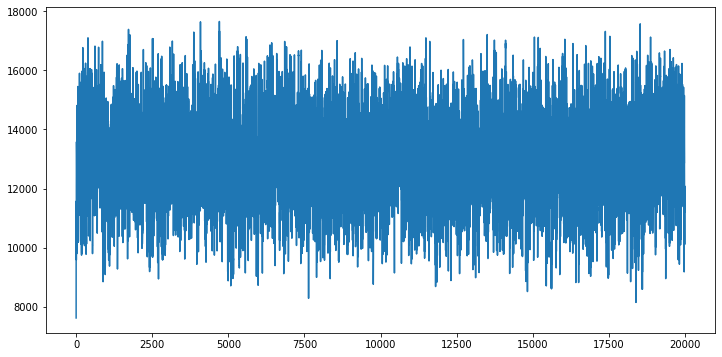

In [5]:
# RL call
_ , inital_s,_,__ = reinforcement_learning(distance_matrix = distance_matrix, exploration_proba = 1, n_episodes = 20000, alpha=0.99, gamma=0.2)

# simulated annealing call
_ , s, Z, seqs  = simulated_annealing(inital_s = inital_s ,num_of_iters = 20000 ,initial_city = 0, T_init = 2500, alpha = 0.99, N = 250, distance_matrix=distance_matrix) 

#Print Results:
print('Best trajectory found using RL + SA:')
print(' -> '.join([ str(x) for x in (str(0)+'-'+s+'-'+str(0)).split('-') ] ))

# visual
tsp_network_viz(s = s, initial_city = 0, distance_matrix = distance_matrix, graph = G, pos = pos, figsize=(12,6))

# seqs
x = []
y = []
for i in Z.keys():
    x.append(i)
    y.append(Z[i])
plt.figure(figsize=(12,6)) 
plt.plot(x,y);

### SA and RL "mixed" structure 

Best trajectory found:
0 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 2 -> 7 -> 0


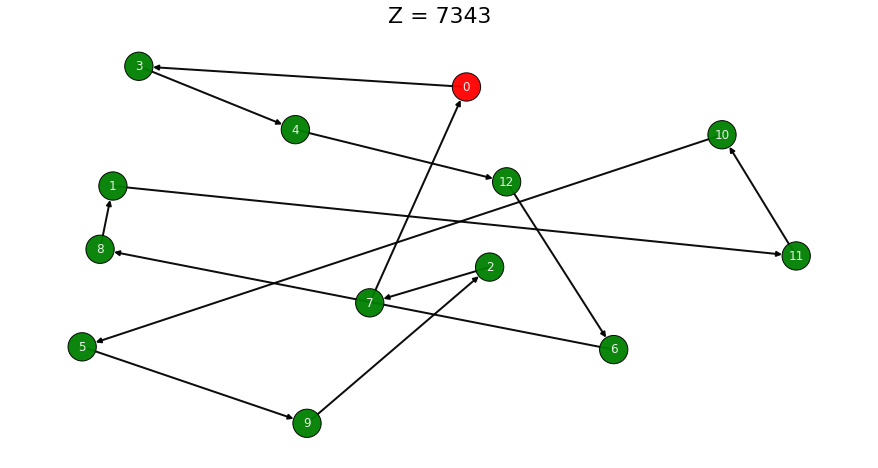

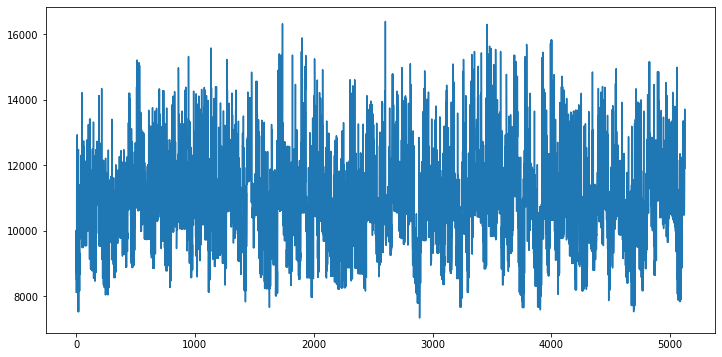

In [6]:
def update_q(q, distance_matrix, state, action, alpha, gamma):
    reward =  1/distance_matrix.loc[state,action] #1/ distance_matrix.loc[state,action]
    delayed_reward = q[action,:].max()
    q[state,action] = q[state,action] + alpha * (reward + gamma * delayed_reward -  q[state,action])
    return q

def reinforced_simulated_annealing(inital_s:str, n_episodes:int , initial_city:int ,  T_init:int , alpha:float , N:int, distance_matrix:pd.DataFrame, gamma:float):
    ''' main RLSA call'''
    # counter for while loop, list of all obj fun, list for strings of sols, sols sin mejorar en una temp, initial temp val, initial solution 
    Z, seqs, M, T, s = {}, {}, 0, T_init, inital_s

    # encoding initial sol
    f_s = encoding(string = s, initial_city = initial_city,  distance_matrix = distance_matrix)

    # store initial sols
    seqs[0] = s
    Z[0] = f_s

    # initializing cities and q matrix
    cities = len(distance_matrix) 
    q = np.zeros([cities,cities])
    seqs_rl = {}
    z_rl = {}

    # iters of schedule
    for i  in range(1,n_episodes + 1):
        # new sol
        s_new = pair_wise(s = s)
        f_s_new = encoding(string = s_new, initial_city = initial_city,  distance_matrix = distance_matrix)
        seqs[i] = s_new
        Z[i] = f_s_new

        # normal dist random nums
        threshold = np.random.uniform(0,1)
        
        # aceptance probability for new solution
        aceptance_prob = min(1, np.exp( (f_s - f_s_new) / T ) )

        # condition to reject or accept new solution
        if (f_s_new < f_s) or (threshold < aceptance_prob):
            s = s_new
            f_s = f_s_new
            M = 0
        else:
            M += 1
            # if change of temp reach balance, update temp
            if M == N: # >=
                # train model to learn from experience
                for e in range(round(n_episodes/(2*N))):
                    # initial city as initial stat
                    visited, state = [0] , 0

                    # posible actions at initial state
                    possible_actions = [ next_city for next_city in range(cities) if next_city not in visited]

                    # iterate until all destinations are visited
                    while possible_actions:
                        if threshold > aceptance_prob: #exploration_proba:
                            action = random.choice(possible_actions)
                        else:       
                            best_action_index = q[state, possible_actions].argmax()
                            action = possible_actions[best_action_index]
                        
                        # update q table
                        q = update_q(q, distance_matrix, state, action,alpha=alpha, gamma=gamma)
                        visited.append(action)
                        state = visited[-1]
                        possible_actions = [ next_city for next_city in range(cities) if next_city not in visited]

                    # record rl sols
                    #exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e)) 
                    seqs_rl[e] = '-'.join([str(y) for y in copy.copy(visited) if y!=0 ] ) #visited
                    z_rl[e] = encoding(string = '-'.join([str(y) for y in copy.copy(visited) if y!=0 ] ), initial_city = initial_city,  distance_matrix = distance_matrix)

                # add to original dictionary
                s = seqs_rl[min(z_rl, key=z_rl.get)]
                f_s =  z_rl[min(z_rl, key=z_rl.get)]
                seqs[e*i] = s
                Z[e*i] = f_s
                M = 0
                T = T*alpha

                # exit condition
                if T <= 0.001:
                    break
        
    # best sequence
    z,s = Z[min(Z, key=Z.get)], seqs[min(Z, key=Z.get)]
    return z, s, Z,seqs

# RL simulated annealing call
inital_s = nearest_neighbor_initial_sol(start = 0, distance_matrix = distance_matrix)
z , s , Z, seq = reinforced_simulated_annealing(inital_s = inital_s, n_episodes = 5000 , initial_city = 0 ,  T_init = 100 , alpha = 0.99 , N = 10, distance_matrix = distance_matrix , gamma = 0.2)

#Print Results:
print('Best trajectory found:')
print(' -> '.join([ str(x) for x in (str(0)+'-'+s+'-'+str(0)).split('-') ] ))

# visual
tsp_network_viz(s = s, initial_city = 0, distance_matrix = distance_matrix, graph = G, pos = pos, figsize=(12,6))

# seqs
x = []
y = []
counter = 0
for i in Z.keys():
    x.append(counter)
    y.append(Z[i])
    counter = counter + 1
plt.figure(figsize=(12,6)) 
plt.plot(x,y);